# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import tueplots.constants.color as tpc
import math
from datetime import datetime

import scipy.optimize as opt
import scipy.integrate
import scipy


from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK
import joypy as jpy
import os

import sys
sys.path.append("../util/")
from dataloader import Loader
from weibull import Weibull
from dates import days_to_date
from misc import ridgeline_plot


from get_params import plot_timeframe
from get_params import plot_timeframe_pdf
from get_params import yearly_params
from get_params import monthly_params



def full_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="full"))
def half_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="half"))
def set_dpi(dpi):
    plt.rcParams.update({"figure.dpi": dpi})

tpc.rgb

'''
plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams.update({"figure.dpi": 300})
# plt.rcParams["font.family"] = "DejaVu Sans"
'''

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "../data"
FIGURE_FOLDER = "../paper/fig"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
METRICS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in METRICS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [2]:
loader = Loader(METRICS, DATA_FOLDER)
metric_files = loader.download_all_metrics(reset=False)

for kind in METRICS:
    print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

kind_df, df = loader.as_dataframe

Files containing wind data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_19961220_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20100101_20191231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_19961219_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20100101_20191231_02115

In [3]:
for metric, metric_df in kind_df.items():
    print(metric_df.dtypes)

STATIONS_ID             int64
MESS_DATUM     datetime64[ns]
  QN_wind               int64
FF_10_wind            float64
DD_10_wind            float64
eor_wind               object
dtype: object
STATIONS_ID                        int64
MESS_DATUM                datetime64[ns]
QN_air_temperature               float64
PP_10_air_temperature            float64
TT_10_air_temperature            float64
TM5_10_air_temperature           float64
RF_10_air_temperature            float64
TD_10_air_temperature            float64
  QN_air_temperature             float64
eor_air_temperature               object
dtype: object
STATIONS_ID                          int64
MESS_DATUM                  datetime64[ns]
QN_precipitation                   float64
RWS_DAU_10_precipitation           float64
RWS_10_precipitation               float64
RWS_IND_10_precipitation           float64
  QN_precipitation                 float64
eor_precipitation                   object
dtype: object
STATIONS_ID             

## Preprocessing

In [4]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df["day"] = wind_df["MESS_DATUM"].dt.day

# First, get rid of NaNs

# a bit more than one year across all years is missing (~ 58000 days) (most of it in 2019)
nans_by_year = wind_df[wind_df["FF_10_wind"].isna()].groupby("year")["STATIONS_ID"].count().reset_index() 
nans_by_year.columns = ["year", "#NaNs"]
print(nans_by_year)
print(f"#NaNs: {wind_df['FF_10_wind'].isna().sum()}")
wind_df.dropna(subset=["FF_10_wind"], inplace=True)
wind_df = wind_df[wind_df["FF_10_wind"] != -999]
rest_df = wind_df.groupby("year")["FF_10_wind"].count().reset_index()
rest_df.columns = ["year", "count"]
rest_df["count"] /= 24 * 6 * 365.25
print('The roughly estimated percentage of valid measurements by year:' )
print(rest_df)

    year  #NaNs
0   2000      4
1   2001     10
2   2002     30
3   2003      5
4   2007      8
5   2009    217
6   2013   1578
7   2014     62
8   2015    196
9   2016   1056
10  2017   1040
11  2018   4868
12  2019  46074
13  2020    950
14  2021   1819
15  2022    277
#NaNs: 58194
The roughly estimated percentage of valid measurements by year:
    year     count
0   1996  0.029641
1   1997  0.848334
2   1998  0.837953
3   1999  0.997433
4   2000  1.001730
5   2001  0.998403
6   2002  0.998023
7   2003  0.994714
8   2004  0.999924
9   2005  0.998992
10  2006  0.998042
11  2007  0.999163
12  2008  1.002053
13  2009  0.995190
14  2010  0.999316
15  2011  0.999316
16  2012  1.002053
17  2013  0.969313
18  2014  0.998137
19  2015  0.995589
20  2016  0.981976
21  2017  0.979542
22  2018  0.906761
23  2019  0.123317
24  2020  0.983991
25  2021  0.906229
26  2022  0.994049


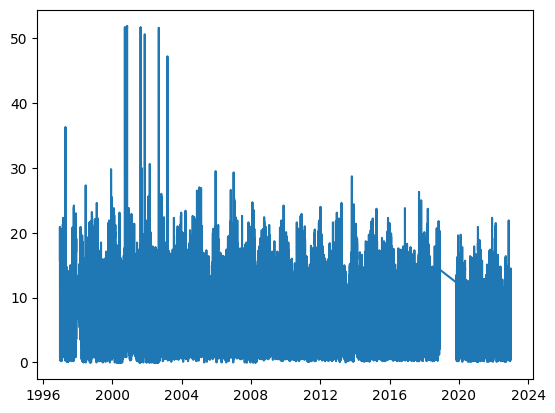

In [5]:
# there are still some outlier left
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df)
plt.show()

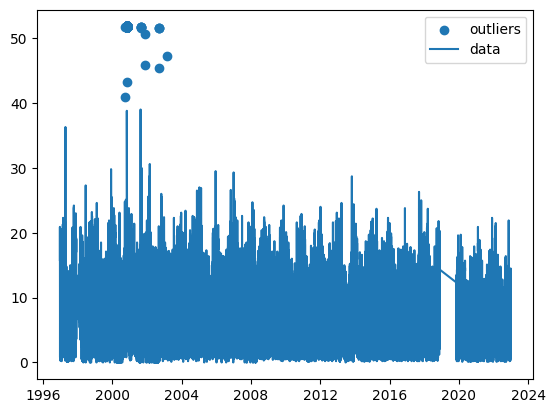

1158


In [6]:
# We choose to exclude the measurements that are above a certain threshold 
# We also exclude the data after month where the large measurement break takes place
#( e.g. in Winter 2000 there is an entire week that yields conctantly 50 m/s, which is very unlikely to refelect the actual wind situation)
zscores = scipy.stats.zscore(wind_df["FF_10_wind"])
threshold = 8

cut_off=pd.to_datetime('2018-11-01')
plt.scatter("MESS_DATUM", "FF_10_wind", data=wind_df[zscores > threshold], label='outliers')
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df[(zscores <= threshold)], label='data' )
plt.legend()
plt.show()
print(wind_df[(zscores > threshold) ].STATIONS_ID.count())


In [7]:
wind_df = wind_df[zscores < 8]

wind_df

,STATIONS_ID,MESS_DATUM,QN_wind,FF_10_wind,DD_10_wind,eor_wind,year,month,day
0,2115,1996-12-19 10:40:00,1,15.8,70.0,eor,1996,12,19
1,2115,1996-12-19 10:50:00,1,16.2,70.0,eor,1996,12,19
2,2115,1996-12-19 11:00:00,1,16.6,70.0,eor,1996,12,19
3,2115,1996-12-19 11:10:00,1,16.0,80.0,eor,1996,12,19
4,2115,1996-12-19 11:20:00,1,16.3,70.0,eor,1996,12,19
...,...,...,...,...,...,...,...,...,...
154742,2115,2022-12-31 23:10:00,3,13.6,230.0,eor,2022,12,31
154743,2115,2022-12-31 23:20:00,3,12.4,230.0,eor,2022,12,31
154744,2115,2022-12-31 23:30:00,3,12.6,230.0,eor,2022,12,31
154745,2115,2022-12-31 23:40:00,3,12.6,230.0,eor,2022,12,31


## Explorative Data Analysis

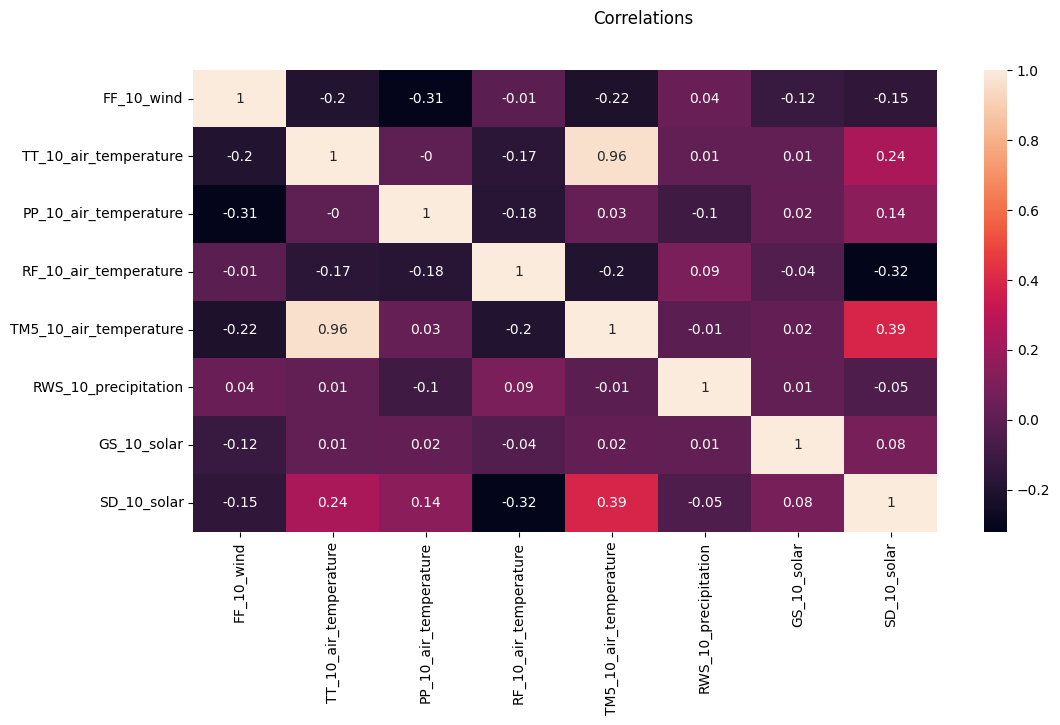

In [8]:
# find out about the correlation of wind speed to other features (turns out it is quite low)
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

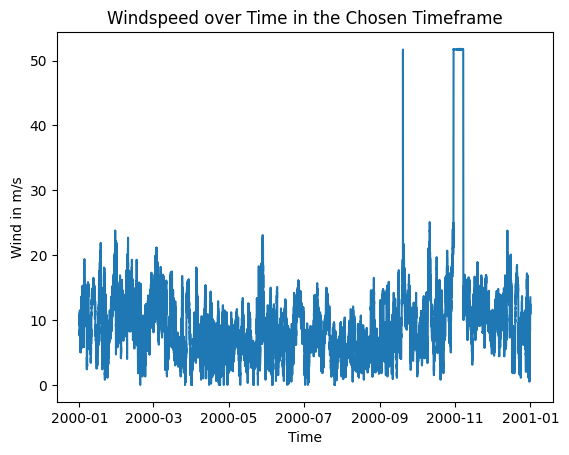

In [9]:
# plot exemplary a chosen timeframe

plot_timeframe(df, 2000)

# Start Fitting Weibull Distributions

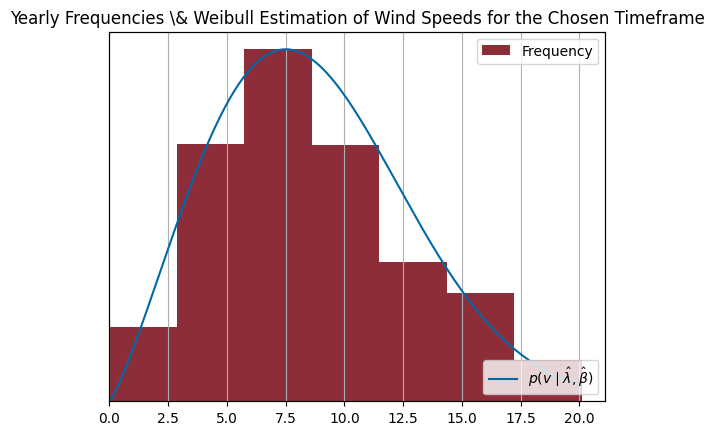

In [10]:
# plot the empiric pdf and the estimated weibull distribution for a chosen timeframe
plot_timeframe_pdf(df, 2002,3)

In [20]:
# compute the weibull parameters for all months and years
yearly_df=yearly_params(1997, 2018, wind_df)
monthly_df=monthly_params(1997, 2018, wind_df)


Text(0, 0.5, 'p(v $\\mid \\hat{\\lambda}, \\hat{\\beta}$)')

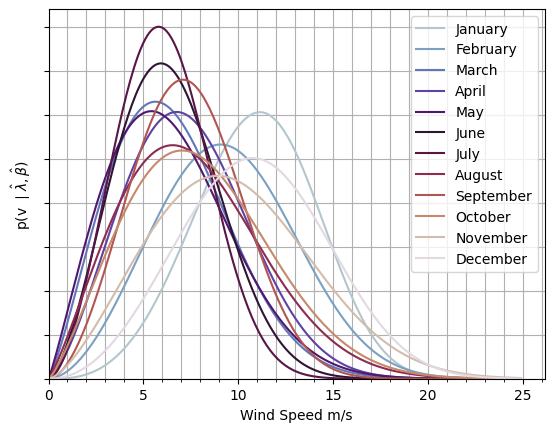

In [21]:
# plot the estimated weibull distributions of all the months of the year 2014

fig, ax = plt.subplots(1, 1)
month_colors = plt.cm.twilight(np.linspace(0,1,13))
for month in range(1,13):
    X = np.arange(0, 25, 0.1)
    target=pd.Period(f'{2014}-{month}', freq='M')
    weibull = Weibull(monthly_df.loc[target, 'param_lambda'],monthly_df.loc[target, 'param_beta'] )
    ax.plot(X, weibull.pdf(X), label=dt.datetime(2014, month, 1).strftime("%B"), color= month_colors[month])
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed m/s")
ax.set_ylabel(r"p(v $\mid \hat{\lambda}, \hat{\beta}$)")


Text(0, 0.5, '$\\mathrm{p}(\\mathrm{v} \\mid \\hat{\\lambda}, \\hat{\\beta})$')

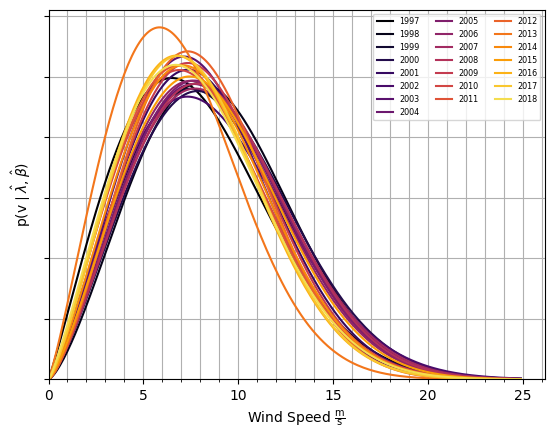

In [22]:
# plot the estimated weibull distribution for each year
fig, ax = plt.subplots(1, 1)
year_colors = plt.cm.inferno(np.linspace(0,1,24))
for year in yearly_df.index:
    X = np.arange(0, 25, 0.1)
    weibull = Weibull(yearly_df.loc[year, 'param_lambda'],yearly_df.loc[year, 'param_beta'] )
    ax.plot(X, weibull.pdf(X), label=year, color= year_colors[year-1997])
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\mathrm{m}}{\mathrm{s}}$")
ax.set_ylabel(r"$\mathrm{p}(\mathrm{v} \mid \hat{\lambda}, \hat{\beta})$")

# Determine the best estimator and analyze the trend in the parameters

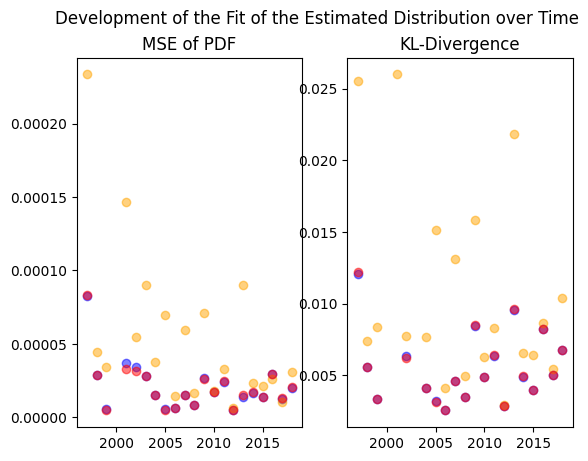

In [24]:
# how does the goodness of fit develop over time (yearly)?

figure, axis = plt.subplots(1, 2)

for y in range(1997, 2019):
    if y==2000:
        continue
    mle_weibull=Weibull.estimate(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    
    fit1= mle_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit3=epf_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])

    axis[0].scatter(y,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0].scatter(y, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0].scatter(y, fit3[0], color='red', alpha=0.5, label='epf method')
    axis[0].set_title("MSE of PDF")
    
    axis[1].scatter(y, fit1[4], color='blue', alpha=0.5) 
    axis[1].scatter(y, fit2[4], color='orange', alpha=0.5)
    axis[1].scatter(y, fit3[4], color='red', alpha=0.5)
    axis[1].set_title("KL-Divergence")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

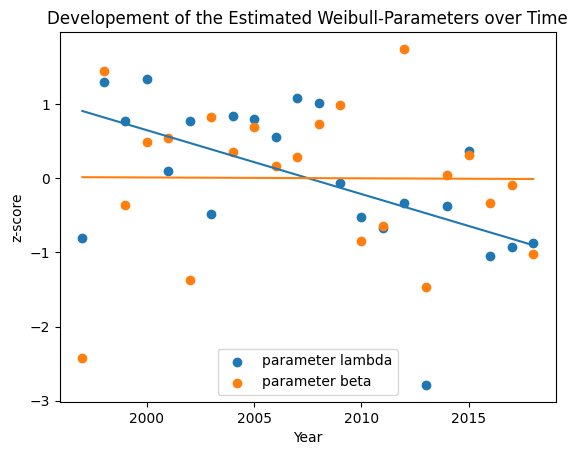

In [28]:
# plot the z-scores of theparameters by year and do linear regresson
plt.scatter(yearly_df.index, (yearly_df['param_lambda'] -yearly_df['param_lambda'].mean())/yearly_df['param_lambda'].std(), label='parameter lambda' )
plt.scatter(yearly_df.index, (yearly_df['param_beta'] -yearly_df['param_beta'].mean())/yearly_df['param_beta'].std(), label='parameter beta' )

l_pol=np.polyfit(yearly_df.index,(yearly_df['param_lambda'] -yearly_df['param_lambda'].mean())/yearly_df['param_lambda'].std(), 1)
l_model = np.poly1d(l_pol)
plt.plot(yearly_df.index,l_model(yearly_df.index))

b_pol=np.polyfit(yearly_df.index,(yearly_df['param_beta'] -yearly_df['param_beta'].mean())/yearly_df['param_lambda'].std(), 1)
b_model = np.poly1d(b_pol)
plt.plot(yearly_df.index,b_model(yearly_df.index))

plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('z-score')
plt.legend()

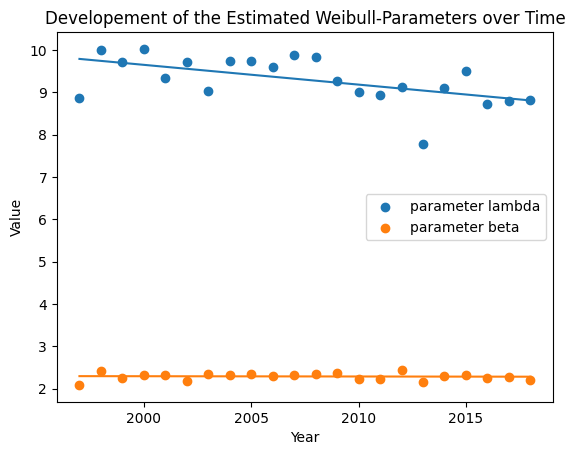

In [29]:
# plot the the parameters by year and do linear regresson
plt.scatter(yearly_df.index, yearly_df['param_lambda'] , label='parameter lambda' )
plt.scatter(yearly_df.index, yearly_df['param_beta'] , label='parameter beta' )

l_pol=np.polyfit(yearly_df.index,yearly_df['param_lambda'], 1)
l_model = np.poly1d(l_pol)
plt.plot(yearly_df.index,l_model(yearly_df.index))

b_pol=np.polyfit(yearly_df.index,yearly_df['param_beta'], 1)
b_model = np.poly1d(b_pol)
plt.plot(yearly_df.index,b_model(yearly_df.index))

plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
# create a dataframe that contains for each year the corresponding data and the estimated weibull distribution
wind_year_dists = []
for year, year_month_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_month_df["FF_10_wind"].dropna().copy().to_numpy()
    weibull = Weibull.estimate(Y)
    wind_year_dists.append([year, Y, weibull])
wind_year_dists = pd.DataFrame(wind_year_dists, columns=["year", "data", "weibull"])
#wind_year_dists

In [17]:
# create a dataframe that contains for each month the corresponding data and the estimated weibull distribution
wind_month_pdfs = []
Y = []
for (year, month), year_month_df in wind_df.groupby(["year", "month"]):
    y = year_month_df["FF_10_wind"].dropna().copy()
    weibull = Weibull.estimate(y)
    Y.append(weibull.pdf(X))
    wind_month_pdfs.append([year, month, weibull, y, weibull.pdf(X)])
wind_month_pdfs = pd.DataFrame(wind_month_pdfs, columns=["year", "month", "weibull", "X", "prob"])
#wind_month_pdfs
        

IndexError: list index out of range

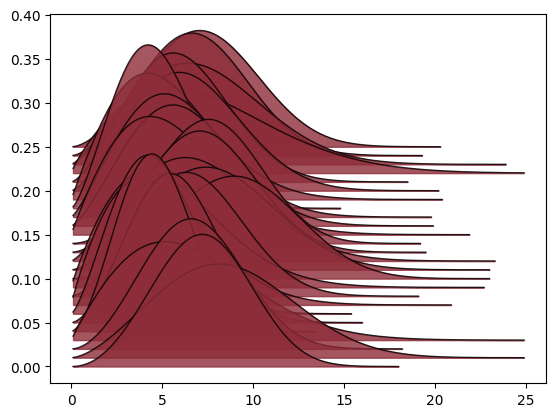

In [18]:
fig, ax = plt.subplots()
labels = [y if y % 2 == 0 else None for y in list(wind_year_dists.year)]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.99, range_threshold=1e-5, alpha=0.8, fill_color=tp.constants.color.rgb.tue_red, fill=True)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.yaxis.set_tick_params(width=1)
ax.set_xlabel(r"Wind Speed $\frac{\mathrm{m}}{\mathrm{s}}$")
ax.set_ylabel("Year")
ax.set_xlim(0, 30)

In [ ]:
full_fig()
fig, ax = plt.subplots()
labels = [yr if yr % 4 == 0 and mth == 1 else None for yr, mth in zip(list(wind_month_pdfs.year), list(wind_month_pdfs.month))]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.999, range_threshold=1e-3, alpha=2/3, linewidth=0.3, fill_color=tp.constants.color.rgb.tue_red, fill=True)
ax.yaxis.grid(True, linewidth=0)
ax.yaxis.set_tick_params(width=0)
ax.set_xlabel(r"Wind Speed $\frac{\mathrm{m}}{\mathrm{s}}$")
ax.set_xlim(0, 30)

(0.0, 30.0)

Error in callback <function _draw_all_if_interactive at 0x000001C0A38E5BC0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpezpupgm3 35adad01b185f64de6ee3600a3339fbc.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (MiKTeX 2.9.7400 64-bit)
entering extended mode
(35adad01b185f64de6ee3600a3339fbc.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
("C:\Program Files\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex/latex/base\size10.clo"))
======================================================================

Unfortunately, the package type1cm could not be installed.
Please check the log file:
C:\Users\gwend\AppData\Local\MiKTeX\2.9\miktex\log\latex.log
======================================================================


! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}
No pages of output.
Transcript written on C:\Users\gwend\.matplotlib\tex.cache\35\ad\tmpezpupgm3\35
adad01b185f64de6ee3600a3339fbc.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpaq4ch1ce 35adad01b185f64de6ee3600a3339fbc.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (MiKTeX 2.9.7400 64-bit)
entering extended mode
(35adad01b185f64de6ee3600a3339fbc.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
("C:\Program Files\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex/latex/base\size10.clo"))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}
No pages of output.
Transcript written on C:\Users\gwend\.matplotlib\tex.cache\35\ad\tmpaq4ch1ce\35
adad01b185f64de6ee3600a3339fbc.log.




<Figure size 675x417.173 with 1 Axes>

# Now turn to the power density evaluation and regeression with the Gaussian Process

In [30]:
# https://en.wikipedia.org/wiki/Density_of_air#Dry_air
air_rho = 1.2250
# 120 meter diameter of wind turbine
sweep_area = math.pi * (70 / 2) ** 2

def expected_density(p: Weibull, A=sweep_area, rho=air_rho):
    # E[1/2 * rho * v^3] = 1/2 * rho * E[v^3] = 1/2 * rho * lambda^3 * G(1 + 3 / beta)
    # 1/2 * rho * v^3: 1/2 * kg/m^3 * m^3 / s^3 = W/m^2
    return 1/2 * rho * p.n_raw_moment(n=3)

def third_raw_moment(X, p: Weibull, rho=air_rho):
    return 1/2 * rho * np.atleast_1d(X) ** 3 * p.pdf(np.atleast_1d(X))

# test_year = wind_year_dists[wind_year_dists.year == 2010]
# X = test_year.data.values.flatten()[0]
# dist = test_year.weibull.values[0]
# x = np.linspace(0, 25, 100)
# integrant = lambda y: third_raw_moment(y, dist)
# result = scipy.integrate.quad(integrant, 5, 25)
# result
# # third_raw_moment(X, test_year.weibull.values[0])

C:\Users\gwend\AppData\Local\Temp\ipykernel_9228\4264049598.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


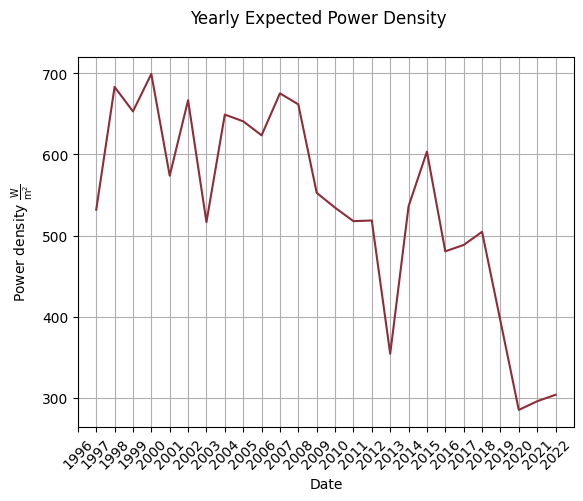

In [31]:
# plot expected values for each year
fig, ax = plt.subplots()
vals = []
for year, year_df in wind_year_dists.groupby("year"):
    if year < 1997: continue
    dist = year_df.weibull.values[0]
    integrant = lambda x: third_raw_moment(x, dist)
    result, _ = scipy.integrate.quad(integrant, 3, 22)
    vals.append((year, result))
years = list(map(lambda t: dt.datetime(t[0], 1, 1), vals))
e = list(map(lambda t: t[1], vals))
ax.plot(years, e, color=tpc.rgb.tue_red)
ax.xaxis.set_major_locator(mdt.YearLocator())
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(1996, 1, 1), dt.datetime(2022, 12, 30)))
ax.set_ylabel(r"Power density $\frac{\mathrm{W}}{\mathrm{m}^2}$")
ax.grid()
fig.suptitle("Yearly Expected Power Density")
fig.show()

Text(0.5, 0.98, 'Monthly Expected Power Density')

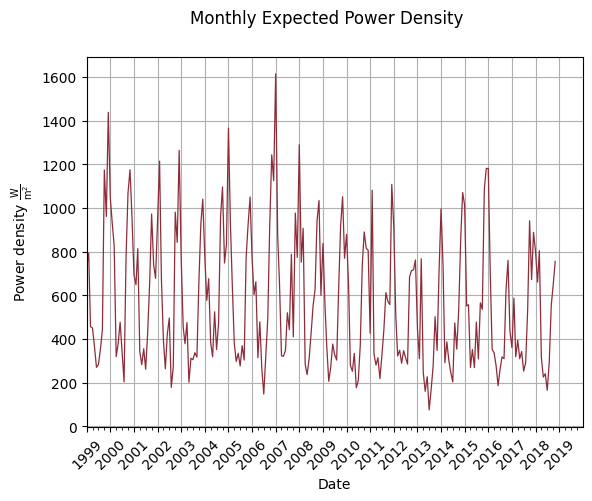

In [32]:
start_y = 1999
start_dt = dt.datetime(start_y, 1, 1)
end_y = 2018 # inclusive
step_size = 1
extrapol_days = 365 * 10

# plot expected values for each month
fig, ax = plt.subplots(1, 1)
vals = []
for (year, month), year_month_df in wind_month_pdfs.groupby(["year", "month"]):
    if year < start_y or year > end_y: continue
    dist = year_month_df.weibull.values[0]
    integrant = lambda x: third_raw_moment(x, dist)
    result, _ = scipy.integrate.quad(integrant, 3, 22)
    vals.append((year, month, result))
    # vals.append((year, month, year_month_df.pdf.values[0].mean))
months = list(map(lambda t: dt.datetime(t[0], t[1], 1), vals))
e = list(map(lambda t: t[2], vals))
ax.plot(months, e, color=tpc.rgb.tue_red, linewidth=0.9)
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
# ax.xaxis.set_minor_formatter(mdt.DateFormatter("%B"))
ax.tick_params(axis='x', which='minor', rotation=90)
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(start_y, 1, 1), dt.datetime(end_y + 1, 12, 31)))
ax.set_ylabel(r"Power density $\frac{\mathrm{W}}{\mathrm{m}^2}$")
ax.grid()
fig.suptitle("Monthly Expected Power Density")

In [34]:
X = np.array(list(map(lambda d: (d - start_dt).days, months))).reshape(-1, 1)
Y = np.array(e)
r = range(0, 365 * (end_y - start_y) + extrapol_days, step_size)
x = np.array(r).reshape(-1, 1)

# TODO Wiener-Kernel?, multiplicative
k1 = 1e-5 * GPK.DotProduct() + GPK.ExpSineSquared(length_scale=1, periodicity=180) + GPK.ExpSineSquared(length_scale=1, periodicity=365) + 0.1 * GPK.RBF(length_scale=30) # * GPK.Matern(length_scale=180, nu=5/2)

# ---
# 0.038**2 * RBF(length_scale=5.62) + 
# 1.14**2 * RBF(length_scale=1.72e+04) * ExpSineSquared(length_scale=1.68, periodicity=365) +
# 0.583**2 * RationalQuadratic(alpha=0.61, length_scale=7.76) +
# 0.0818**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.00635)
long_term_trend_kernel = 1e-5**2 * GPK.DotProduct(Y.max() - Y.min()) ** 2
yearly_trend_kernel = 250**2 * GPK.ExpSineSquared(length_scale=1.15, periodicity=365)
seasonal_kernel = 50**2 * GPK.ExpSineSquared(length_scale=1.5, periodicity=180) * (5e-3**2 * GPK.RBF(length_scale=1.5))
irregularities_kernel = 1.5e-1 * GPK.RBF(length_scale=30)
k2 = yearly_trend_kernel + long_term_trend_kernel + seasonal_kernel + irregularities_kernel
# ---

gp = GP(kernel=k2, alpha=0.25, normalize_y=True, random_state=1, optimizer=None)

In [35]:
full_fig()
fig, ax = plt.subplots()

sample_steps = 7

x_sample = np.array(range(0, 365 * (end_y + 1 - start_y), sample_steps)).reshape(-1, 1)
samples = gp.sample_y(x_sample, n_samples=8, random_state=42)
pred_mean, pred_std = gp.predict(x_sample, return_std=True)
x_sample_dt = days_to_date(start_dt, x_sample)

ax.plot(x_sample_dt, samples, linewidth=0.75)
ax.plot(x_sample_dt, pred_mean, label="Mean", color=tpc.rgb.tue_red)
ax.plot(x_sample_dt, pred_mean + pred_std, color=tpc.rgb.tue_red, linewidth=0.5) 
ax.plot(x_sample_dt, pred_mean - pred_std, color=tpc.rgb.tue_red, linewidth=0.5)
ax.fill_between(x_sample_dt, pred_mean + pred_std, pred_mean - pred_std, alpha=0.15, color=tpc.rgb.tue_red, label="std. dev.")
ax.legend(ncols=1)
ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y + 1, 1, 1))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.tick_params(axis='x', which="major", rotation=45)
ax.grid()
ax.set_ylabel(r"Power density $\frac{\mathrm{W}}{\mathrm{m}^2}$")
ax.set_title("Prior Samples")

Text(0.5, 1.0, 'Prior Samples')

Error in callback <function _draw_all_if_interactive at 0x00000207D69F9C60> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpj9go_7mx 35adad01b185f64de6ee3600a3339fbc.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (MiKTeX 2.9.7400 64-bit)
entering extended mode
(35adad01b185f64de6ee3600a3339fbc.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
("C:\Program Files\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex/latex/base\size10.clo"))
======================================================================

Unfortunately, the package type1cm could not be installed.
Please check the log file:
C:\Users\gwend\AppData\Local\MiKTeX\2.9\miktex\log\latex.log
======================================================================


! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}
No pages of output.
Transcript written on C:\Users\gwend\.matplotlib\tex.cache\35\ad\tmpj9go_7mx\35
adad01b185f64de6ee3600a3339fbc.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp3jcoisr9 35adad01b185f64de6ee3600a3339fbc.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (MiKTeX 2.9.7400 64-bit)
entering extended mode
(35adad01b185f64de6ee3600a3339fbc.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
("C:\Program Files\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex/latex/base\size10.clo"))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}
No pages of output.
Transcript written on C:\Users\gwend\.matplotlib\tex.cache\35\ad\tmp3jcoisr9\35
adad01b185f64de6ee3600a3339fbc.log.




<Figure size 675x417.173 with 1 Axes>

In [36]:
gp.fit(X, Y)
pred_mean, std = gp.predict(x, return_std=True)
samples = gp.sample_y(x_sample, n_samples=5)
x_dt = days_to_date(start_dt, x)

fig, ax = plt.subplots()

X_dt = days_to_date(start_dt, X)
ax.plot(X_dt, Y, "--", color=tpc.rgb.tue_darkblue, linewidth=0.6, alpha=2/3)
ax.plot(X_dt, Y, ".", label="Ground Truth", markersize=3, color=tpc.rgb.tue_darkblue, alpha=0.8)

ax.axvline(dt.datetime(end_y + 1, 1, 1), color=tpc.rgb.tue_darkgreen, linewidth=1.5, label="data cut-off")
ax.axhline(0, color="black", linewidth=1)

ax.plot(x_sample_dt, samples, alpha=0.05, color="black", linewidth=0.5)
ax.plot(x_dt, pred_mean, "-", linewidth=1, label="mean", color=tpc.rgb.tue_red)
ax.plot(x_dt, pred_mean + std, "-", alpha=0.25, color=tpc.rgb.tue_red, linewidth=0.2)
ax.plot(x_dt, pred_mean - std, "-", alpha=0.25, color=tpc.rgb.tue_red, linewidth=0.2)
ax.fill_between(x_dt, pred_mean + std, pred_mean - std, color="red", alpha=0.1, label="std. dev.")


ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y, 1, 1) + dt.timedelta(extrapol_days))
ax.set_ylim(-200)
ax.set_ylabel(r"Power density $\frac{\mathrm{W}}{\mathrm{m}^2}$")
ax.set_xlabel("Year")
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.legend(ncols=1)
ax.tick_params(axis='x', which="major", rotation=45)
ax.grid()
fig.suptitle("Monthly Expected Power Density")
plt.savefig(os.path.join(FIGURE_FOLDER, "gp_pred.pdf"))

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpr01dn3fo 35adad01b185f64de6ee3600a3339fbc.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (MiKTeX 2.9.7400 64-bit)
entering extended mode
(35adad01b185f64de6ee3600a3339fbc.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
("C:\Program Files\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex/latex/base\size10.clo"))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}
No pages of output.
Transcript written on C:\Users\gwend\.matplotlib\tex.cache\35\ad\tmpr01dn3fo\35
adad01b185f64de6ee3600a3339fbc.log.




Error in callback <function _draw_all_if_interactive at 0x00000207D69F9C60> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp1955okq7 35adad01b185f64de6ee3600a3339fbc.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (MiKTeX 2.9.7400 64-bit)
entering extended mode
(35adad01b185f64de6ee3600a3339fbc.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
("C:\Program Files\MiKTeX 2.9\tex/latex/base\article.cls"
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex/latex/base\size10.clo"))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}
No pages of output.
Transcript written on C:\Users\gwend\.matplotlib\tex.cache\35\ad\tmp1955okq7\35
adad01b185f64de6ee3600a3339fbc.log.


